In [2]:
import torch
import nibabel as nib
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

print(f"Cuda disponible", torch.cuda.is_available())

# Comprobamos algunas imágenes
data_path = "/home/mariopasc/Python/Datasets/copy-ds-epilepsy/ds-epilepsy/sub-00001/anat"
path = [x for x in os.listdir(data_path) if x.endswith(".nii.gz")]
print(f"Paths:", path)

Cuda disponible True
Paths: ['sub-00001_acq-T2sel_FLAIR.nii.gz', 'sub-00001_acq-iso08_T1w.nii.gz', 'sub-00001_acq-T2sel_FLAIR_roi.nii.gz']


T2 flair (height, width, depth, channels):  (160, 256, 256)
T1-w (height, width, depth, channels):  (208, 320, 320)
ROI (height, width, depth, channels):  (160, 256, 256)


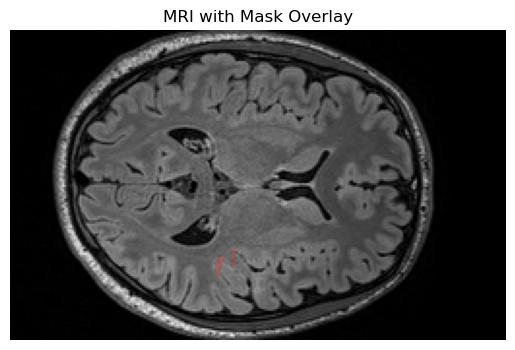

In [3]:
t2FLAIR = nib.load(os.path.join(data_path, path[0])).get_fdata()
t1WEIGHT = nib.load(os.path.join(data_path, path[1])).get_fdata()
roi = nib.load(os.path.join(data_path, path[2])).get_fdata()

print(f"T2 flair (height, width, depth, channels): ", t2FLAIR.shape)
print(f"T1-w (height, width, depth, channels): ", t1WEIGHT.shape)
print(f"ROI (height, width, depth, channels): ", roi.shape)


def overlay_mask_on_mri(ax, mask, mri, mask_color='red', alpha=0.5):
    ax.imshow(mri, cmap='gray')
    cmap_mask = mcolors.ListedColormap(['none', mask_color])
    ax.imshow(mask, cmap=cmap_mask, alpha=alpha)
    ax.axis('off')
    ax.set_title('MRI with Mask Overlay')

# Create a figure and axis
fig, ax = plt.subplots()
overlay_mask_on_mri(ax, roi[:, :, 132], t2FLAIR[:, :, 132], mask_color='red', alpha=0.2)
plt.show()

132 tiene 4 contornos
133 tiene 2 contornos
140 tiene 1 contorno

Para poder realizar el entrenamiento de la red YOLOv8 necesitamos conseguir el contorno del objeto y almacenarlo en un fichero .txt con al tipo de clase que queremos segmentar (supondremos 0 para lesión) con el siguiente formato:
                                                 `<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>`
Para encontrar el contorno de las máscaras se utilizará la función `cv.findContours(image, mode, method)`. Dando una imagen y un modo de obtención del contorno, así como un método de aproximación, se pueden conseguir dos salidas: contours (lista de contornos) y hierarchy (matriz que contiene información sobre la topología de contornos). Se deja más información aquí:

- `image`: Es la imagen de entrada, que debe ser una imagen binaria (blanco y negro) o una imagen en escala de grises. Los píxeles blancos representan los objetos de interés, mientras que los píxeles negros representan el fondo.
  
- `mode`: Especifica el modo de recuperación de contorno. Puede ser uno de los siguientes valores:
  - `cv.RETR_EXTERNAL`: Recupera solo los contornos externos.
  - `cv.RETR_LIST`: Recupera todos los contornos sin ningún tipo de jerarquía.
  - `cv.RETR_CCOMP`: Recupera todos los contornos y organiza sus relaciones en un árbol de dos niveles.
  - `cv.RETR_TREE`: Recupera todos los contornos y organiza sus relaciones en un árbol completo.

- `method`: Especifica el método de aproximación de contorno. Puede ser uno de los siguientes valores:
  - `cv.CHAIN_APPROX_NONE`: Almacena todos los puntos del contorno.
  - `cv.CHAIN_APPROX_SIMPLE`: Comprime los segmentos horizontales, verticales y diagonales y deja solo sus puntos finales.


In [3]:
roi_uint8 = np.uint8(roi[:, :, 132])

contours, _ = cv.findContours(roi_uint8, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

# Iterar sobre la lista de contornos y obtener el número de puntos en cada uno
for i, contorno in enumerate(contours):
    num_puntos = len(contorno)
    print("Contorno {} tiene {} puntos.".format(i+1, num_puntos))

Contorno 1 tiene 24 puntos.
Contorno 2 tiene 4 puntos.
Contorno 3 tiene 1 puntos.
Contorno 4 tiene 22 puntos.


Ahora que tenemos el contorno (debemos suponer que puede haber más de uno) tenemos que obtener el fichero con el formato correcto. 

In [4]:
def contours_YOLO_format(contours, height, width, output_path):
    if len(contours) > 0:
        with open(output_path, 'w') as f:
            for i, contorno in enumerate(contours):
                normalized = contorno / np.array([width, height])
                str_contour = ' '.join([f"{coord:.3f}" for coord in normalized.flatten()])
                str_contour = "0 "+ str_contour
                f.write(f"{str_contour}\n")
    else:
        return

width = roi_uint8.shape[0]
height = roi_uint8.shape[1]
out_path = "/home/mariopasc/Python/Projects/BSC_final/epilepsy_segment/output_104.txt"
contours_YOLO_format(contours=contours,
                     height=height,
                     width=width,
                     output_path=out_path)

contours_YOLO_format(contours=[],
                     height=height,
                     width=width,
                     output_path="/home/mariopasc/Python/Projects/BSC_final/epilepsy_segment/output_noexiste.txt")

Y así podemos asegurar que las imágenes sin contornos detectados generen un fichero, al entrenar la red con datos que no tienen contornos asociados se ayuda a reducir los falsos positivos.

Vamos a seguir explorando el dataset. Vamos a obtener los ids de los pacientes que no tienen asociado un ROI.

In [5]:
data_path = "/home/mariopasc/Python/Datasets/ds004199-download"

# Obtenemos los pacientes y los ordenamos (para commprender mejor la estructura)
pacientes = [file for file in os.listdir(data_path) if file.startswith("sub-")]
pacientes_num = [int(pac.lstrip("sub-")) for pac in pacientes]
pacientes_ordenados = sorted(zip(pacientes, pacientes_num), key=lambda x: x[1])
pacientes_ordenados, _ = zip(*pacientes_ordenados)
pacientes_ordenados = list(pacientes_ordenados)
# Ahora vamos a ver cuántos pacientes no tienen una roi asociada
with open("/home/mariopasc/Python/Projects/BSC_final/epilepsy_segment/bash-scripts/pacientes-test/pacientes-test.txt", 'r') as f:
    pacientes_noROI = [pac for pac in f.readlines()]
    pacientes_noROI = [pac.rstrip("\n") for pac in pacientes_noROI]

print(f"Pacientes sin nii.gz roi: {len(pacientes_noROI)/len(pacientes_ordenados) *100}%")

FileNotFoundError: [Errno 2] No such file or directory: '/home/mariopasc/Python/Projects/BSC_final/epilepsy_segment/bash-scripts/pacientes-test/pacientes-test.txt'

Vamos a comprobar que el archivo roi no esté implementado en algún canal...

Paths: ['sub-00002_acq-iso08_T1w.nii.gz', 'sub-00002_acq-T2sel_FLAIR.nii.gz']
Shape con ROI (160, 256, 256), shape sin roi (157, 256, 256)


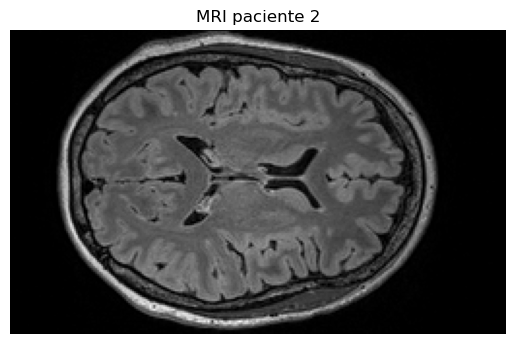

In [4]:
data_path = "/home/mariopasc/Python/Datasets/ds004199-download/sub-00002/anat"
path = [x for x in os.listdir(data_path) if x.endswith(".nii.gz")]
print(f"Paths:", path)
t2FLAIR_2 = nib.load(os.path.join(data_path, path[1])).get_fdata()

print(f"Shape con ROI {t2FLAIR.shape}, shape sin roi {t2FLAIR_2.shape}")
plt.imshow(t2FLAIR_2[:, :, 140], cmap="gray")
plt.title("MRI paciente 2")
plt.axis("off")
plt.show()

Como podemos ver, parece que no tiene el ROI en otro canal, estas imágenes no son útiles, por lo que serán descartadas. Serán útiles entonces los pacientes:

In [24]:
pacientes =[pac for pac in pacientes_ordenados if pac not in pacientes_noROI]
with open("/home/mariopasc/Python/Projects/BSC_final/epilepsy_segment/pacientes-validos.txt", "w") as file:
    for pac in pacientes: file.write(f"{pac}\n")

Con una serie de programas de la consola (bash) vamos a crear una estructura más organizada con los ficheros del proyecto. Hemos podido distinguir 3 tipos de ficheros de imagen .nii.gz por paciente, uno T1w, otro T2FLAIR, y otro con el ROI. Vamos entonces a organizar estos ficheros por pacientes en 3 directorios distintos:

ds-epilepsy
├── roi
│   └── sub-00XXX
│       └── sub-00XXX_acq-T2sel_FLAIR_roi.nii.gz
├── T1w-study
│   └── sub-00XXX
│       ├── sub-00XXX_acq-iso08_T1w.json
│       └── sub-00XXX_acq-iso08_T1w.nii.gz
└── T2flair-study
    └── sub-00XXX
        ├── sub-00XXX_acq-T2sel_FLAIR_roi.nii.gz
        └── sub-00XXX_acq-T2sel_FLAIR_roi.json

Estos programas han sido creados *ad hoc* para este proyecto, por lo que los scripts tienen rutas como variables definidas que no son replicables para otros proyectos. 

Ahora se va a proceder a hacer una clase de procesamiento de datos más general que trabaje sobre esa estructura que se ha descrito anteriormente. 